In [1]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from helpers import *
import yfinance as yf

/Users/irfanjamil/anaconda3/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
import time

In [4]:
cursor = get_cursor()

In [5]:
from KalshiClientsBaseV2 import ExchangeClient

In [6]:
ndx = yf.Ticker('^NDX').history(period='max')
spx = yf.Ticker('^SPX').history(period='max')

spx = spx.reset_index()[['Date', 'Open', 'Close']]
ndx = ndx.reset_index()[['Date', 'Open', 'Close']]

spx['Date'] = spx.apply(lambda x: date(x['Date'].year, x['Date'].month, x['Date'].day), axis=1)
ndx['Date'] = ndx.apply(lambda x: date(x['Date'].year, x['Date'].month, x['Date'].day), axis=1)

In [7]:
spx[spx['Date']==date(2022,5,2)]

,Date,Open,Close
23696,2022-05-02,4130.609863,4155.379883


In [8]:
prod_email, prod_password = get_kalshi_creds()
prod_api_base = "https://trading-api.kalshi.com/trade-api/v2" 
exchange_client = ExchangeClient(exchange_api_base=prod_api_base, email = prod_email, password = prod_password)

In [9]:
abbr_to_month = {v: k for k, v in month_to_abbr.items()}

In [10]:
from KalshiClientsBaseV2 import HttpError

In [37]:
#Kalshi SP500 range market goes back to April 28, 2022, size of each range change from 50 to 25 after May 17, 2023
import math
dt = date(2022,4,28)
lb = None
ub = None
mp = None
spx_d = {'ticker': [], 'bid': [], 'ask': [], 'lb': [], 'ub': [], 'open': [], 'close': [], 'date': []}
while dt < date.today():
    retry = False
    try:
        spx_open = float(spx[spx['Date']==dt]['Open'].to_list()[0])
        spx_close = float(spx[spx['Date']==dt]['Close'].to_list()[0])
    except IndexError:
        dt += timedelta(days = 1)
        continue
    if dt <= date(2023, 5, 17):
        lb = spx_open - spx_open % 50
        ub = lb + 50
        mp = int((lb+ub)/2)
    else:
        lb = spx_open - spx_open % 25
        ub = lb + 25
        mp = math.floor((lb + ub)/2)
    ticker = 'INX-' + str(dt.year-2000) + month_to_abbr[dt.month]
    if dt.day < 10:
        ticker += '0' + str(dt.day)
    else:
        ticker += str(dt.day)
    ticker += '-B' + str(mp)
    ts = int(time.mktime(datetime(dt.year, dt.month, dt.day, 9, 30, 0).timetuple()))
    try:
        r = exchange_client.get_market_history(ticker, min_ts = ts)
    except HttpError:
        ticker = ticker[:3] + 'D' + ticker[3:]
        retry = True

    if retry:
        try:
            r = exchange_client.get_market_history(ticker, min_ts = ts)
        except:
            dt += timedelta(days = 1)
            continue
    info = r['history'][0]
    first_ts = datetime.fromtimestamp(info['ts'])
    if first_ts.hour == 9:
        bb = info['yes_bid']
        ba = info['yes_ask']
        spx_d['ticker'].append(ticker)
        spx_d['bid'].append(bb)
        spx_d['ask'].append(ba)
        spx_d['lb'].append(lb)
        spx_d['ub'].append(ub)
        spx_d['date'].append(dt)        
        spx_d['open'].append(spx_open)
        spx_d['close'].append(spx_close)

    dt += timedelta(days=1)
spx_df = pd.DataFrame(data=spx_d)

In [12]:
spx_df

,ticker,bid,ask,lb,ub,open,close,date
0,INX-22APR28-B4225,15,19,4200.0,4250.0,4222.580078,4287.500000,2022-04-28
1,INX-22APR29-B4275,0,4,4250.0,4300.0,4253.750000,4131.930176,2022-04-29
2,INX-22MAY02-B4125,21,25,4100.0,4150.0,4130.609863,4155.379883,2022-05-02
3,INX-22MAY03-B4175,40,44,4150.0,4200.0,4159.779785,4175.479980,2022-05-03
4,INX-22MAY04-B4175,42,45,4150.0,4200.0,4181.180176,4300.169922,2022-05-04
...,...,...,...,...,...,...,...,...
367,INX-24FEB13-B4962,14,15,4950.0,4975.0,4967.939941,4953.169922,2024-02-13
368,INX-24FEB14-B4987,56,58,4975.0,5000.0,4976.439941,5000.620117,2024-02-14
369,INX-24FEB15-B5012,44,45,5000.0,5025.0,5003.140137,5029.729980,2024-02-15
370,INX-24FEB16-B5037,69,71,5025.0,5050.0,5031.129883,5005.569824,2024-02-16


In [38]:
spx_df['in_interval'] = spx_df.apply(lambda x: 1 if x['close']>= x['lb'] and x['close']<x['ub'] else 0, axis=1)
spx_df

,ticker,bid,ask,lb,ub,open,close,date,in_interval
0,INX-22APR29-B4275,20,22,4250.0,4300.0,4253.750000,4131.930176,2022-04-29,0
1,INX-22MAY02-B4125,22,26,4100.0,4150.0,4130.609863,4155.379883,2022-05-02,0
2,INX-22MAY03-B4175,22,25,4150.0,4200.0,4159.779785,4175.479980,2022-05-03,1
3,INX-22MAY04-B4175,23,25,4150.0,4200.0,4181.180176,4300.169922,2022-05-04,0
4,INX-22MAY05-B4275,21,23,4250.0,4300.0,4270.430176,4146.870117,2022-05-05,0
...,...,...,...,...,...,...,...,...,...
372,INX-24FEB13-B4962,27,29,4950.0,4975.0,4967.939941,4953.169922,2024-02-13,1
373,INX-24FEB14-B4987,33,39,4975.0,5000.0,4976.439941,5000.620117,2024-02-14,0
374,INX-24FEB15-B5012,32,37,5000.0,5025.0,5003.140137,5029.729980,2024-02-15,0
375,INX-24FEB16-B5037,29,48,5025.0,5050.0,5031.129883,5005.569824,2024-02-16,0


In [41]:
spx_df['in_interval'].describe()

count    377.000000
mean       0.403183
std        0.491189
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: in_interval, dtype: float64

In [39]:
#Kalshi NASDAQ100 range market goes back to May 1, 2022, size of each range change is 100
import math
dt = date(2022,5,1)
lb = None
ub = None
mp = None
ndx_d = {'ticker': [], 'bid': [], 'ask': [], 'lb': [], 'ub': [], 'open': [], 'close': [], 'date': []}
while dt < date.today():
    retry = False
    try:
        ndx_open = float(ndx[ndx['Date']==dt]['Open'].to_list()[0])
        ndx_close = float(ndx[ndx['Date']==dt]['Close'].to_list()[0])
    except IndexError:
        dt += timedelta(days = 1)
        continue
   
    lb = ndx_open - ndx_open % 100
    ub = lb + 100
    mp = int((lb + ub)/2)
    ticker = 'NASDAQ100-' + str(dt.year-2000) + month_to_abbr[dt.month]
    if dt.day < 10:
        ticker += '0' + str(dt.day)
    else:
        ticker += str(dt.day)
    ticker += '-B' + str(mp)
    ts = int(time.mktime(datetime(dt.year, dt.month, dt.day, 9, 30, 0).timetuple()))
    try:
        r = exchange_client.get_market_history(ticker, min_ts = ts)
    except HttpError:
        ticker = ticker[:9] + 'D' + ticker[9:]
        retry = True

    if retry:
        try:
            r = exchange_client.get_market_history(ticker, min_ts = ts)
        except:
            dt += timedelta(days = 1)
            continue
    info = r['history'][0]
    first_ts = datetime.fromtimestamp(info['ts'])
    if first_ts.hour == 9:
        bb = info['yes_bid']
        ba = info['yes_ask']
        ndx_d['ticker'].append(ticker)
        ndx_d['bid'].append(bb)
        ndx_d['ask'].append(ba)
        ndx_d['lb'].append(lb)
        ndx_d['ub'].append(ub)
        ndx_d['date'].append(dt)        
        ndx_d['open'].append(ndx_open)
        ndx_d['close'].append(ndx_close)

    dt += timedelta(days=1)
ndx_df = pd.DataFrame(data=ndx_d)

In [17]:
ndx_df

,ticker,bid,ask,lb,ub,open,close,date
0,NASDAQ100-22MAY02-B12850,21,25,12800.0,12900.0,12864.830078,13075.849609,2022-05-02
1,NASDAQ100-22MAY03-B13050,31,35,13000.0,13100.0,13045.349609,13089.900391,2022-05-03
2,NASDAQ100-22MAY04-B13150,26,30,13100.0,13200.0,13110.299805,13535.709961,2022-05-04
3,NASDAQ100-22MAY05-B13350,1,3,13300.0,13400.0,13344.790039,12850.549805,2022-05-05
4,NASDAQ100D-22MAY09-B12450,7,9,12400.0,12500.0,12465.910156,12187.719727,2022-05-09
...,...,...,...,...,...,...,...,...
361,NASDAQ100-24FEB13-B17550,57,58,17500.0,17600.0,17519.800781,17600.419922,2024-02-13
362,NASDAQ100-24FEB14-B17750,50,51,17700.0,17800.0,17728.900391,17807.630859,2024-02-14
363,NASDAQ100-24FEB15-B17850,65,66,17800.0,17900.0,17815.320312,17845.720703,2024-02-15
364,NASDAQ100-24FEB16-B17850,57,62,17800.0,17900.0,17853.589844,17685.980469,2024-02-16


In [40]:
ndx_df['in_interval'] = ndx_df.apply(lambda x: 1 if x['close'] >= x['lb'] and x['close'] < x['ub'] else 0, axis=1)

In [47]:
ndx_df

,ticker,bid,ask,lb,ub,open,close,date,in_interval
0,NASDAQ100-22MAY02-B12850,16,19,12800.0,12900.0,12864.830078,13075.849609,2022-05-02,0
1,NASDAQ100-22MAY03-B13050,14,18,13000.0,13100.0,13045.349609,13089.900391,2022-05-03,1
2,NASDAQ100-22MAY04-B13150,14,18,13100.0,13200.0,13110.299805,13535.709961,2022-05-04,0
3,NASDAQ100-22MAY05-B13350,14,17,13300.0,13400.0,13344.790039,12850.549805,2022-05-05,0
4,NASDAQ100D-22MAY10-B12450,14,18,12400.0,12500.0,12496.839844,12345.860352,2022-05-10,0
...,...,...,...,...,...,...,...,...,...
369,NASDAQ100-24FEB13-B17550,4,27,17500.0,17600.0,17519.800781,17600.419922,2024-02-13,0
370,NASDAQ100-24FEB14-B17750,24,30,17700.0,17800.0,17728.900391,17807.630859,2024-02-14,0
371,NASDAQ100-24FEB15-B17850,26,31,17800.0,17900.0,17815.320312,17845.720703,2024-02-15,1
372,NASDAQ100-24FEB16-B17850,7,28,17800.0,17900.0,17853.589844,17685.980469,2024-02-16,0


In [42]:
ndx_df['in_interval'].describe()

count    374.000000
mean       0.262032
std        0.440329
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: in_interval, dtype: float64

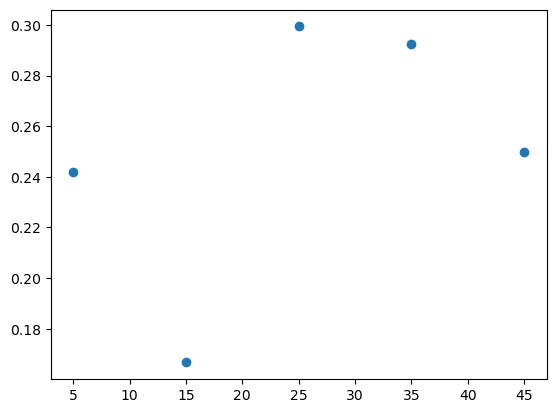

In [43]:
d = {'opening_bid': [], 'empirical_portion_of_in_interval': []}
for lb in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]:
    slice_df = ndx_df[(ndx_df['bid']>=lb) & (ndx_df['bid'] < lb+10)]
    slice_avg = slice_df['in_interval'].describe()['mean']
    d['opening_bid'].append(lb+5)
    d['empirical_portion_of_in_interval'].append(slice_avg)

plt.scatter(d['opening_bid'],d['empirical_portion_of_in_interval'])

In [44]:
df = pd.DataFrame(d)
df

,opening_bid,empirical_portion_of_in_interval
0,5,0.241935
1,15,0.166667
2,25,0.299401
3,35,0.292308
4,45,0.250000
5,55,NaN
6,65,NaN
7,75,NaN
8,85,NaN
9,95,NaN


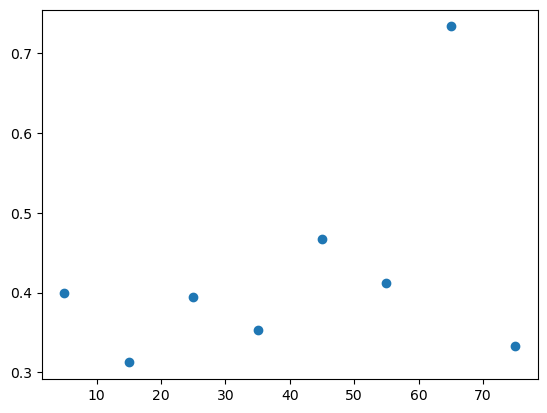

In [45]:
d = {'opening_bid': [], 'empirical_portion_of_in_interval': []}
for lb in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]:
    slice_df = spx_df[(spx_df['bid']>=lb) & (spx_df['bid'] < lb+10)]
    slice_avg = slice_df['in_interval'].describe()['mean']
    d['opening_bid'].append(lb+5)
    d['empirical_portion_of_in_interval'].append(slice_avg)

plt.scatter(d['opening_bid'],d['empirical_portion_of_in_interval'])

In [46]:
df = pd.DataFrame(d)
df

,opening_bid,empirical_portion_of_in_interval
0,5,0.400000
1,15,0.312500
2,25,0.394737
3,35,0.353333
4,45,0.466667
5,55,0.411765
6,65,0.733333
7,75,0.333333
8,85,NaN
9,95,NaN


In [53]:
'''
It's possible that, for the NDX100 range markets, bids in the 40s or higher when the market opens are far too high
'''
for x in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
    mean = ndx_df[ndx_df['bid']>x]['in_interval'].describe()['mean']
    print(x, mean, sep=', ')

10, 0.26366559485530544
20, 0.2925764192139738
30, 0.3
40, 0.4
50, nan
60, nan
70, nan
80, nan
90, nan


In [54]:
for x in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
    mean = spx_df[spx_df['bid']>x]['in_interval'].describe()['mean']
    print(x, mean, sep=', ')

10, 0.4017094017094017
20, 0.40978593272171254
30, 0.40160642570281124
40, 0.47058823529411764
50, 0.5588235294117647
60, 0.7058823529411765
70, 0.0
80, nan
90, nan


In [68]:
ndx

,Date,Open,Close
0,1985-10-01,110.620003,112.139999
1,1985-10-02,112.139999,110.824997
2,1985-10-03,110.839996,110.870003
3,1985-10-04,110.870003,110.074997
4,1985-10-07,110.074997,108.199997
...,...,...,...
9670,2024-02-14,17728.900391,17807.630859
9671,2024-02-15,17815.320312,17845.720703
9672,2024-02-16,17853.589844,17685.980469
9673,2024-02-20,17591.169922,17546.099609


In [76]:
from GaussianMLE import *

dt = date(2022,5,1)
lb = None
ub = None
mp = None

log_returns = ndx[(ndx['Date']<dt) & (ndx['Date']>date(2000, 1, 1))].apply(lambda x: np.log(x['Close']) - np.log(x['Open']), axis=1).to_list()
mean, sigma = fit_data(log_returns)
cur = datetime(2024, 2, 21, 9, 30, 0)

ndx_monte_carlo_d = {'lb': [], 'ub': [], 'open': [], 'close': [],'implied_prob': [], 'date': []}
while dt < date.today():
    try:
        ndx_open = float(ndx[ndx['Date']==dt]['Open'].to_list()[0])
        ndx_close = float(ndx[ndx['Date']==dt]['Close'].to_list()[0])
    except IndexError:
        dt += timedelta(days = 1)
        continue
    eod_samples = simulate(ndx_open, mean, sigma, cur)
    lb = ndx_open - ndx_open % 100
    ub = lb + 100
    imp_p = in_interval_prob(lb, ub, eod_samples)
    ndx_monte_carlo_d['lb'].append(lb)
    ndx_monte_carlo_d['ub'].append(ub)
    ndx_monte_carlo_d['open'].append(ndx_open)
    ndx_monte_carlo_d['close'].append(ndx_close)
    ndx_monte_carlo_d['implied_prob'].append(imp_p)
    ndx_monte_carlo_d['date'].append(dt)
    dt += timedelta(days=1)
    
ndx_mc_df = pd.DataFrame(data=ndx_monte_carlo_d)

Optimization terminated successfully.
         Current function value: -2.770588
         Iterations: 4
         Function evaluations: 9


/Users/irfanjamil/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/Users/irfanjamil/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


In [77]:
ndx_mc_df

,lb,ub,open,close,implied_prob,date
0,12800.0,12900.0,12864.830078,13075.849609,0.201704,2022-05-02
1,13000.0,13100.0,13045.349609,13089.900391,0.199599,2022-05-03
2,13100.0,13200.0,13110.299805,13535.709961,0.194091,2022-05-04
3,13300.0,13400.0,13344.790039,12850.549805,0.195462,2022-05-05
4,12700.0,12800.0,12776.860352,12693.530273,0.202544,2022-05-06
...,...,...,...,...,...,...
448,17500.0,17600.0,17519.800781,17600.419922,0.148328,2024-02-13
449,17700.0,17800.0,17728.900391,17807.630859,0.147393,2024-02-14
450,17800.0,17900.0,17815.320312,17845.720703,0.145444,2024-02-15
451,17800.0,17900.0,17853.589844,17685.980469,0.146838,2024-02-16


In [78]:
ndx_mc_df['implied_prob'].describe()

count    453.000000
mean       0.193745
std        0.025377
min        0.145444
25%        0.171236
50%        0.198636
75%        0.215008
max        0.243590
Name: implied_prob, dtype: float64

In [79]:
ndx_mc_df['in_interval'] = ndx_mc_df.apply(lambda x: 1 if x['close'] >= x['lb'] and x['close'] < x['ub'] else 0, axis=1)

In [80]:
for x in [0.14, 0.16, 0.18, 0.20, 0.22, 0.24]:
    slice_df = ndx_mc_df[(ndx_mc_df['implied_prob'] >= x) & (ndx_mc_df['implied_prob'] < x+0.02)]
    mean = slice_df['in_interval'].describe()['mean']
    print(x, mean, sep=', ')
    

0.14, 0.2916666666666667
0.16, 0.27906976744186046
0.18, 0.30158730158730157
0.2, 0.23484848484848486
0.22, 0.2125
0.24, 0.0


In [ ]:
'''
model as currently is is not good at all
'''

In [55]:
ndx_df

,ticker,bid,ask,lb,ub,open,close,date,in_interval
0,NASDAQ100-22MAY02-B12850,16,19,12800.0,12900.0,12864.830078,13075.849609,2022-05-02,0
1,NASDAQ100-22MAY03-B13050,14,18,13000.0,13100.0,13045.349609,13089.900391,2022-05-03,1
2,NASDAQ100-22MAY04-B13150,14,18,13100.0,13200.0,13110.299805,13535.709961,2022-05-04,0
3,NASDAQ100-22MAY05-B13350,14,17,13300.0,13400.0,13344.790039,12850.549805,2022-05-05,0
4,NASDAQ100D-22MAY10-B12450,14,18,12400.0,12500.0,12496.839844,12345.860352,2022-05-10,0
...,...,...,...,...,...,...,...,...,...
369,NASDAQ100-24FEB13-B17550,4,27,17500.0,17600.0,17519.800781,17600.419922,2024-02-13,0
370,NASDAQ100-24FEB14-B17750,24,30,17700.0,17800.0,17728.900391,17807.630859,2024-02-14,0
371,NASDAQ100-24FEB15-B17850,26,31,17800.0,17900.0,17815.320312,17845.720703,2024-02-15,1
372,NASDAQ100-24FEB16-B17850,7,28,17800.0,17900.0,17853.589844,17685.980469,2024-02-16,0


In [62]:
for x in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]:
    slice_df = ndx_df[(ndx_df['bid']>=x) & (ndx_df['bid']<x+10)]
    count = slice_df.shape[0]
    mean = slice_df['in_interval'].describe()['mean']
    print('Min Bid: ' + str(x) + ', Max Bid: ' + str(x+9) + ', Sample Size: ' + str(count) + ', In Interval Avg: ' + str(mean))
    

Min Bid: 0, Max Bid: 9, Sample Size: 62, In Interval Avg: 0.24193548387096775
Min Bid: 10, Max Bid: 19, Sample Size: 72, In Interval Avg: 0.16666666666666666
Min Bid: 20, Max Bid: 29, Sample Size: 167, In Interval Avg: 0.2994011976047904
Min Bid: 30, Max Bid: 39, Sample Size: 65, In Interval Avg: 0.2923076923076923
Min Bid: 40, Max Bid: 49, Sample Size: 8, In Interval Avg: 0.25
Min Bid: 50, Max Bid: 59, Sample Size: 0, In Interval Avg: nan
Min Bid: 60, Max Bid: 69, Sample Size: 0, In Interval Avg: nan
Min Bid: 70, Max Bid: 79, Sample Size: 0, In Interval Avg: nan
Min Bid: 80, Max Bid: 89, Sample Size: 0, In Interval Avg: nan
Min Bid: 90, Max Bid: 99, Sample Size: 0, In Interval Avg: nan


In [63]:
for x in [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]:
    slice_df = ndx_df[(ndx_df['bid']>=x) & (ndx_df['bid']<x+5)]
    count = slice_df.shape[0]
    mean = slice_df['in_interval'].describe()['mean']
    print('Min Bid: ' + str(x) + ', Max Bid: ' + str(x+4) + ', Sample Size: ' + str(count) + ', In Interval Avg: ' + str(mean))
    

Min Bid: 0, Max Bid: 4, Sample Size: 49, In Interval Avg: 0.2653061224489796
Min Bid: 5, Max Bid: 9, Sample Size: 13, In Interval Avg: 0.15384615384615385
Min Bid: 10, Max Bid: 14, Sample Size: 21, In Interval Avg: 0.19047619047619047
Min Bid: 15, Max Bid: 19, Sample Size: 51, In Interval Avg: 0.1568627450980392
Min Bid: 20, Max Bid: 24, Sample Size: 75, In Interval Avg: 0.32
Min Bid: 25, Max Bid: 29, Sample Size: 92, In Interval Avg: 0.2826086956521739
Min Bid: 30, Max Bid: 34, Sample Size: 48, In Interval Avg: 0.2708333333333333
Min Bid: 35, Max Bid: 39, Sample Size: 17, In Interval Avg: 0.35294117647058826
Min Bid: 40, Max Bid: 44, Sample Size: 6, In Interval Avg: 0.3333333333333333
Min Bid: 45, Max Bid: 49, Sample Size: 2, In Interval Avg: 0.0
Min Bid: 50, Max Bid: 54, Sample Size: 0, In Interval Avg: nan
Min Bid: 55, Max Bid: 59, Sample Size: 0, In Interval Avg: nan
Min Bid: 60, Max Bid: 64, Sample Size: 0, In Interval Avg: nan
Min Bid: 65, Max Bid: 69, Sample Size: 0, In Interval

In [57]:
for x in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]:
    slice_df = ndx_df[(ndx_df['ask']>=x) & (ndx_df['ask']<x+10)]
    count = slice_df.shape[0]
    mean = slice_df['in_interval'].describe()['mean']
    print('Min Ask: ' + str(x) + ', Max Ask: ' + str(x+9) + ', Sample Size: ' + str(count) + ', In Interval Avg: ' + str(mean))
    

Min Ask: 0, Max Ask: 9, Sample Size: 0, In Interval Avg: nan
Min Ask: 10, Max Ask: 19, Sample Size: 10, In Interval Avg: 0.2
Min Ask: 20, Max Ask: 29, Sample Size: 84, In Interval Avg: 0.2857142857142857
Min Ask: 30, Max Ask: 39, Sample Size: 181, In Interval Avg: 0.26519337016574585
Min Ask: 40, Max Ask: 49, Sample Size: 43, In Interval Avg: 0.32558139534883723
Min Ask: 50, Max Ask: 59, Sample Size: 7, In Interval Avg: 0.14285714285714285
Min Ask: 60, Max Ask: 69, Sample Size: 3, In Interval Avg: 0.3333333333333333
Min Ask: 70, Max Ask: 79, Sample Size: 3, In Interval Avg: 0.3333333333333333
Min Ask: 80, Max Ask: 89, Sample Size: 9, In Interval Avg: 0.0
Min Ask: 90, Max Ask: 99, Sample Size: 19, In Interval Avg: 0.2631578947368421


In [59]:
for x in [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]:
    slice_df = ndx_df[(ndx_df['ask']>=x) & (ndx_df['ask']<x+5)]
    count = slice_df.shape[0]
    mean = slice_df['in_interval'].describe()['mean']
    print('Min Ask: ' + str(x) + ', Max Ask: ' + str(x+4) + ', Sample Size: ' + str(count) + ', In Interval Avg: ' + str(mean))
    

Min Ask: 0, Max Ask: 4, Sample Size: 0, In Interval Avg: nan
Min Ask: 5, Max Ask: 9, Sample Size: 0, In Interval Avg: nan
Min Ask: 10, Max Ask: 14, Sample Size: 0, In Interval Avg: nan
Min Ask: 15, Max Ask: 19, Sample Size: 10, In Interval Avg: 0.2
Min Ask: 20, Max Ask: 24, Sample Size: 23, In Interval Avg: 0.2608695652173913
Min Ask: 25, Max Ask: 29, Sample Size: 61, In Interval Avg: 0.29508196721311475
Min Ask: 30, Max Ask: 34, Sample Size: 94, In Interval Avg: 0.2127659574468085
Min Ask: 35, Max Ask: 39, Sample Size: 87, In Interval Avg: 0.3218390804597701
Min Ask: 40, Max Ask: 44, Sample Size: 23, In Interval Avg: 0.391304347826087
Min Ask: 45, Max Ask: 49, Sample Size: 20, In Interval Avg: 0.25
Min Ask: 50, Max Ask: 54, Sample Size: 5, In Interval Avg: 0.2
Min Ask: 55, Max Ask: 59, Sample Size: 2, In Interval Avg: 0.0
Min Ask: 60, Max Ask: 64, Sample Size: 3, In Interval Avg: 0.3333333333333333
Min Ask: 65, Max Ask: 69, Sample Size: 0, In Interval Avg: nan
Min Ask: 70, Max Ask: 74

In [ ]:
'''
For NDX100, 9:30 am ET prices, for "in the money" ranges

These results support the notion that buying at the ask or posting a limit bid when the bid, ask are in the 20s
or lower may profitable. AND, selling at the bid or posting a limit ask when the bid, ask are in the 30s or higher
may be profitable

might be worthwhile to backtest this and write a script to run a live test moving forwards
'''

In [56]:
spx_df

,ticker,bid,ask,lb,ub,open,close,date,in_interval
0,INX-22APR29-B4275,20,22,4250.0,4300.0,4253.750000,4131.930176,2022-04-29,0
1,INX-22MAY02-B4125,22,26,4100.0,4150.0,4130.609863,4155.379883,2022-05-02,0
2,INX-22MAY03-B4175,22,25,4150.0,4200.0,4159.779785,4175.479980,2022-05-03,1
3,INX-22MAY04-B4175,23,25,4150.0,4200.0,4181.180176,4300.169922,2022-05-04,0
4,INX-22MAY05-B4275,21,23,4250.0,4300.0,4270.430176,4146.870117,2022-05-05,0
...,...,...,...,...,...,...,...,...,...
372,INX-24FEB13-B4962,27,29,4950.0,4975.0,4967.939941,4953.169922,2024-02-13,1
373,INX-24FEB14-B4987,33,39,4975.0,5000.0,4976.439941,5000.620117,2024-02-14,0
374,INX-24FEB15-B5012,32,37,5000.0,5025.0,5003.140137,5029.729980,2024-02-15,0
375,INX-24FEB16-B5037,29,48,5025.0,5050.0,5031.129883,5005.569824,2024-02-16,0


In [67]:
spx

,Date,Open,Close
0,1927-12-30,17.660000,17.660000
1,1928-01-03,17.760000,17.760000
2,1928-01-04,17.719999,17.719999
3,1928-01-05,17.549999,17.549999
4,1928-01-06,17.660000,17.660000
...,...,...,...
24145,2024-02-14,4976.439941,5000.620117
24146,2024-02-15,5003.140137,5029.729980
24147,2024-02-16,5031.129883,5005.569824
24148,2024-02-20,4989.319824,4975.509766


In [65]:
for x in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]:
    slice_df = spx_df[(spx_df['bid']>=x) & (spx_df['bid']<x+10)]
    count = slice_df.shape[0]
    mean = slice_df['in_interval'].describe()['mean']
    print('Min Bid: ' + str(x) + ', Max Bid: ' + str(x+9) + ', Sample Size: ' + str(count) + ', In Interval Avg: ' + str(mean))
    

Min Bid: 0, Max Bid: 9, Sample Size: 25, In Interval Avg: 0.4
Min Bid: 10, Max Bid: 19, Sample Size: 16, In Interval Avg: 0.3125
Min Bid: 20, Max Bid: 29, Sample Size: 76, In Interval Avg: 0.39473684210526316
Min Bid: 30, Max Bid: 39, Sample Size: 150, In Interval Avg: 0.35333333333333333
Min Bid: 40, Max Bid: 49, Sample Size: 75, In Interval Avg: 0.4666666666666667
Min Bid: 50, Max Bid: 59, Sample Size: 17, In Interval Avg: 0.4117647058823529
Min Bid: 60, Max Bid: 69, Sample Size: 15, In Interval Avg: 0.7333333333333333
Min Bid: 70, Max Bid: 79, Sample Size: 3, In Interval Avg: 0.3333333333333333
Min Bid: 80, Max Bid: 89, Sample Size: 0, In Interval Avg: nan
Min Bid: 90, Max Bid: 99, Sample Size: 0, In Interval Avg: nan


In [66]:
for x in [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]:
    slice_df = spx_df[(spx_df['bid']>=x) & (spx_df['bid']<x+5)]
    count = slice_df.shape[0]
    mean = slice_df['in_interval'].describe()['mean']
    print('Min Bid: ' + str(x) + ', Max Bid: ' + str(x+4) + ', Sample Size: ' + str(count) + ', In Interval Avg: ' + str(mean))
    

Min Bid: 0, Max Bid: 4, Sample Size: 24, In Interval Avg: 0.4166666666666667
Min Bid: 5, Max Bid: 9, Sample Size: 1, In Interval Avg: 0.0
Min Bid: 10, Max Bid: 14, Sample Size: 8, In Interval Avg: 0.375
Min Bid: 15, Max Bid: 19, Sample Size: 8, In Interval Avg: 0.25
Min Bid: 20, Max Bid: 24, Sample Size: 36, In Interval Avg: 0.3611111111111111
Min Bid: 25, Max Bid: 29, Sample Size: 40, In Interval Avg: 0.425
Min Bid: 30, Max Bid: 34, Sample Size: 70, In Interval Avg: 0.32857142857142857
Min Bid: 35, Max Bid: 39, Sample Size: 80, In Interval Avg: 0.375
Min Bid: 40, Max Bid: 44, Sample Size: 44, In Interval Avg: 0.4772727272727273
Min Bid: 45, Max Bid: 49, Sample Size: 31, In Interval Avg: 0.45161290322580644
Min Bid: 50, Max Bid: 54, Sample Size: 13, In Interval Avg: 0.46153846153846156
Min Bid: 55, Max Bid: 59, Sample Size: 4, In Interval Avg: 0.25
Min Bid: 60, Max Bid: 64, Sample Size: 6, In Interval Avg: 0.8333333333333334
Min Bid: 65, Max Bid: 69, Sample Size: 9, In Interval Avg: 0.

In [58]:
for x in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]:
    slice_df = spx_df[(spx_df['ask']>=x) & (spx_df['ask']<x+10)]
    count = slice_df.shape[0]
    mean = slice_df['in_interval'].describe()['mean']
    print('Min Ask: ' + str(x) + ', Max Ask: ' + str(x+9) + ', Sample Size: ' + str(count) + ', In Interval Avg: ' + str(mean))
    

Min Ask: 0, Max Ask: 9, Sample Size: 0, In Interval Avg: nan
Min Ask: 10, Max Ask: 19, Sample Size: 0, In Interval Avg: nan
Min Ask: 20, Max Ask: 29, Sample Size: 20, In Interval Avg: 0.4
Min Ask: 30, Max Ask: 39, Sample Size: 91, In Interval Avg: 0.2967032967032967
Min Ask: 40, Max Ask: 49, Sample Size: 146, In Interval Avg: 0.4246575342465753
Min Ask: 50, Max Ask: 59, Sample Size: 72, In Interval Avg: 0.3888888888888889
Min Ask: 60, Max Ask: 69, Sample Size: 20, In Interval Avg: 0.6
Min Ask: 70, Max Ask: 79, Sample Size: 16, In Interval Avg: 0.625
Min Ask: 80, Max Ask: 89, Sample Size: 3, In Interval Avg: 0.3333333333333333
Min Ask: 90, Max Ask: 99, Sample Size: 6, In Interval Avg: 0.5


In [61]:
for x in [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]:
    slice_df = spx_df[(spx_df['ask']>=x) & (spx_df['ask']<x+5)]
    count = slice_df.shape[0]
    mean = slice_df['in_interval'].describe()['mean']
    print('Min Ask: ' + str(x) + ', Max Ask: ' + str(x+4) + ', Sample Size: ' + str(count) + ', In Interval Avg: ' + str(mean))
    

Min Ask: 0, Max Ask: 4, Sample Size: 0, In Interval Avg: nan
Min Ask: 5, Max Ask: 9, Sample Size: 0, In Interval Avg: nan
Min Ask: 10, Max Ask: 14, Sample Size: 0, In Interval Avg: nan
Min Ask: 15, Max Ask: 19, Sample Size: 0, In Interval Avg: nan
Min Ask: 20, Max Ask: 24, Sample Size: 3, In Interval Avg: 0.3333333333333333
Min Ask: 25, Max Ask: 29, Sample Size: 17, In Interval Avg: 0.4117647058823529
Min Ask: 30, Max Ask: 34, Sample Size: 25, In Interval Avg: 0.32
Min Ask: 35, Max Ask: 39, Sample Size: 66, In Interval Avg: 0.2878787878787879
Min Ask: 40, Max Ask: 44, Sample Size: 75, In Interval Avg: 0.48
Min Ask: 45, Max Ask: 49, Sample Size: 71, In Interval Avg: 0.36619718309859156
Min Ask: 50, Max Ask: 54, Sample Size: 48, In Interval Avg: 0.375
Min Ask: 55, Max Ask: 59, Sample Size: 24, In Interval Avg: 0.4166666666666667
Min Ask: 60, Max Ask: 64, Sample Size: 11, In Interval Avg: 0.7272727272727273
Min Ask: 65, Max Ask: 69, Sample Size: 9, In Interval Avg: 0.4444444444444444
Min 

In [ ]:
'''
For SPX, 9:30 am ET prices, "in the money" ranges

Placing bids or taking asks where bid, ask < 30s may be profitable. Otherwise, data is 
not telling a coherent story really

'''

In [28]:
exchange_client.get_market_history('INX-24FEB21-B4987')

{'ticker': 'INX-24FEB21-B4987',
 'history': [{'yes_price': 0,
   'yes_bid': 0,
   'yes_ask': 48,
   'no_bid': 52,
   'no_ask': 100,
   'volume': 0,
   'open_interest': 0,
   'ts': 1708463114},
  {'yes_price': 0,
   'yes_bid': 0,
   'yes_ask': 25,
   'no_bid': 75,
   'no_ask': 100,
   'volume': 0,
   'open_interest': 0,
   'ts': 1708465090},
  {'yes_price': 25,
   'yes_bid': 0,
   'yes_ask': 48,
   'no_bid': 52,
   'no_ask': 100,
   'volume': 14,
   'open_interest': 14,
   'ts': 1708465283},
  {'yes_price': 25,
   'yes_bid': 27,
   'yes_ask': 48,
   'no_bid': 52,
   'no_ask': 73,
   'volume': 14,
   'open_interest': 14,
   'ts': 1708465284},
  {'yes_price': 25,
   'yes_bid': 27,
   'yes_ask': 41,
   'no_bid': 59,
   'no_ask': 73,
   'volume': 14,
   'open_interest': 14,
   'ts': 1708465286},
  {'yes_price': 25,
   'yes_bid': 24,
   'yes_ask': 41,
   'no_bid': 59,
   'no_ask': 76,
   'volume': 14,
   'open_interest': 14,
   'ts': 1708465371},
  {'yes_price': 25,
   'yes_bid': 27,
   'yes

In [29]:
exchange_client.get_market_history('INX-24FEB21-B4987').keys()

dict_keys(['ticker', 'history', 'cursor'])

In [35]:
d = {'bid': [], 'ask': [], 'ticker': [], 'ts': []}

r = exchange_client.get_market_history('INX-24FEB21-B4987', min_ts=1708543800)
for x in r['history']:
    d['bid'].append(x['yes_bid'])
    d['ask'].append(x['yes_ask'])
    d['ticker'].append(r['ticker'])
    d['ts'].append(datetime.fromtimestamp(x['ts']))
cursor = r['cursor']
while cursor is not None and len(cursor) > 0:
    r = exchange_client.get_market_history('INX-24FEB21-B4987', cursor=cursor, min_ts = 1708543800)
    for x in r['history']:
        d['bid'].append(x['yes_bid'])
        d['ask'].append(x['yes_ask'])
        d['ticker'].append(r['ticker'])
        d['ts'].append(datetime.fromtimestamp(x['ts']))
    cursor = r['cursor']

df = pd.DataFrame(data=d)

In [36]:
df

,bid,ask,ticker,ts
0,8,10,INX-24FEB21-B4987,2024-02-21 14:30:00
1,8,9,INX-24FEB21-B4987,2024-02-21 14:30:01
2,8,9,INX-24FEB21-B4987,2024-02-21 14:30:05
3,8,10,INX-24FEB21-B4987,2024-02-21 14:30:05
4,9,10,INX-24FEB21-B4987,2024-02-21 14:30:05
...,...,...,...,...
1892,96,97,INX-24FEB21-B4987,2024-02-21 15:59:51
1893,96,97,INX-24FEB21-B4987,2024-02-21 15:59:56
1894,96,97,INX-24FEB21-B4987,2024-02-21 15:59:56
1895,96,98,INX-24FEB21-B4987,2024-02-21 15:59:57


In [33]:
int(time.mktime(datetime(2024, 2, 21, 14, 30, 0).timetuple()))

1708543800

In [34]:
datetime.fromtimestamp(1708543800)

datetime.datetime(2024, 2, 21, 14, 30)

In [ ]:
def get_interval_bounds(s):
    split = s.split(' ')
    if 'or' in s and 'below' in s:
      return [0, float(split[0].replace(',',''))]
    elif 'or' in s and 'above' in s:
      return [float(split[0].replace(',','')), np.inf]
    elif 'to' in s:
      return [float(split[0].replace(',','')), float(split[2].replace(',',''))]
    else:
      raise Exception
    

In [ ]:
cursor.execute('select Date, Open, Close from spx;')
spx_rows = cursor.fetchall()
spx_d = {'Date': [], 'Open': [], 'Close': []}

cursor.execute('select Date, Open, Close from ndx;')
ndx_rows = cursor.fetchall()
ndx_d = {'Date': [], 'Open': [], 'Close': []}

for row in spx_rows:
    spx_d['Date'].append(row[0])
    spx_d['Open'].append(row[1])
    spx_d['Close'].append(row[2])
    
for row in ndx_rows:
    ndx_d['Date'].append(row[0])
    ndx_d['Open'].append(row[1])
    ndx_d['Close'].append(row[2])

spx = pd.DataFrame(data=spx_d)
ndx = pd.DataFrame(data=ndx_d)

In [ ]:

d = {'ticker': [], 'bid': [], 'ask': [], 'lb': [], 'ub': [], 'open': [], 'close': [], 'date': []}
for ticker in tickers:
    ticker_dt = ticker.split('-')[1]
    year = 2000 + int(ticker_dt[:2])
    day = int(ticker_dt[-2:])
    month = abbr_to_month[ticker_dt[2:5]]
    ts = int(time.mktime(datetime(year, month, day, 14, 30, 0).timetuple()))
    r = exchange_client.get_market_history(ticker, min_ts=ts)
    info = r['history'][0]
    first_ts = datetime.fromtimestamp(info['ts'])
    if first_ts.hour == 14:
        bb = info['yes_bid']
        ba = info['yes_ask']
        get_mark_resp = exchange_client.get_market(ticker)['market']
        subtitle = get_mark_resp['subtitle']
        ticker_date = datetime.strptime(get_mark_resp['close_time'], '%Y-%m-%dT%H:%M:%SZ').date()
        d['ticker'].append(ticker)
        d['bid'].append(bb)
        d['ask'].append(ba)
        interval = get_interval_bounds(subtitle)
        d['lb'].append(interval[0])
        d['ub'].append(interval[1])
        d['date'].append(ticker_date)
        if 'INX' in ticker:
            row = spx[spx['Date']==ticker_date]
            if row.shape[0]>0:
                d['open'].append(float(row['Open'].to_list()[0]))
                d['close'].append(float(row['Close'].to_list()[0]))
            else:
                d['open'].append(None)
                d['close'].append(None)
        else:
            row = ndx[ndx['Date']==ticker_date]
            if row.shape[0]>0:
                d['open'].append(float(row['Open'].to_list()[0]))
                d['close'].append(float(row['Close'].to_list()[0]))
            else:
                d['open'].append(None)
                d['close'].append(None)
        

df = pd.DataFrame(data=d)

In [ ]:
df[(df['open'].isnull()==False) & (df['open'] >= df['lb']) & (df['open']<=df['ub'])]

In [ ]:
spx